###### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes

###### Submission deadline: 7 pm, Tuesday 6 Apr 2021

**Student ID(s):**     1080613


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import confusion_matrix
from itertools import product
from scipy import stats
from copy import copy

%matplotlib inline

# This notebook will only run on Python 3.8 or above, since no version
# was specified in the assignment spec. I assume this is OK. If you are trying
# to run the code on Python 3.6, the Walrus operator (:=) will need to be 
# removed in a few places since this assignment expression was introduced in 3.8

# The body parts corresponding to each of the 11 numbered coordinates.
body_labels = {1: 'head', 2: 'chest', 3: 'r_elbow', 
               4: 'r_hand', 5: 'l_elbow', 6: 'l_hand',
               7: 'hips', 8: 'r_knee', 9: 'r_foot',
               10: 'l_knee', 11: 'l_foot'}

# A list of the possible yoga poses
poses = ['bridge', 'childs', 'downwarddog', 'mountain', 'plank',
         'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']

In [3]:
def preprocess(train_file_path, test_file_path):
    """Takes two CSV file paths and reads the data. Rearranges the columns so that corresponding X, Y coordinates
    are adjacent. Adds a multiindex over the columns so cells can be indexed by body part, axis, and pose."""
    
    dataframes = []
    # This funky list comprehension zips together the corresponding coordinates (1, 12), (2, 13), ...
    # then unpacks the tuples returned from the zip into one list. nice
    col_order = [j for i in zip(range(1, 12), range(12, 23)) for j in i]
    
    for file_path in train_file_path, test_file_path:
        # Load the data from the CSV files using the first column as an index. Consider 9999 to be an NA value.
        data = pd.read_csv(file_path, header=None, index_col=0, na_values=9999)

        # Drop rows that contain only (all) NA values, for some reason there are 15 of these in the training set.
        data.dropna(how='all', inplace=True)

        # Rearrange the columns so that corresponding X and Y coordinates are adjacent.
        data = data[col_order]

        # Create a MultiIndex to easily identify our coordinates and body parts
        index = pd.MultiIndex.from_product((body_labels.values(), ('x', 'y')), names=['Body Part', 'Axis'])
        data.columns = index
        data.index.name = 'pose'

        dataframes.append(data)

    return dataframes

In [4]:
def visualise(data):
    """Generates a 2x11 histograms to visualise the distribution of coordinates for each
    body part along each axis. This did not end up being used in the report, so probably
    doesn't need to be assessed :)"""

    colors = ('#3A0751', '#8865FF', '#FF6FA5', '#FB9EC4', '#FFDAC0', '#FFC7BA',
              '#F2C85B', '#FBA465', '#F86E51', '#EE3E38', '#D1193E')
    fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(15,20))
    
    for i, body_part in body_labels.items():
        i -= 1
        axis_x = axs[2 * int(i / 4), i % 4]
        axis_x.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
        sns.histplot(data[body_part]['x'], ax=axis_x, stat='density', color=colors[i]).set_title(body_part)
        mu_x, std_x = stats.norm.fit(data[body_part]['x'].dropna())
        xmin, xmax = axis_x.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu_x, std_x)
        axis_x.plot(x, p, 'r', linewidth=1)

        axis_y = axs[2 * int(i / 4) + 1, i % 4]
        axis_y.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
        sns.histplot(data[body_part]['y'], ax=axis_y, stat='density', color=colors[i])
        mu_y, std_y = stats.norm.fit(data[body_part]['y'].dropna())
        xmin, xmax = axis_y.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu_y, std_y)
        axis_y.plot(x, p, 'g', linewidth=1)

    fig.tight_layout()


In [5]:
def train(train_data):
    """Returns a dictionary containing the prior distribution for each pose. Extracts the means and
    standard deviations of each coordinate for each body part for each pose."""

    # Using a prior based on the observed probabilities in the training data. When my model was less
    # refined I found that a uniform prior worked better, but that's no longer the case. If you want 
    # to try the uniform prior, use:
    # prior = {k: 0.1 for k in poses}  # instead.
    prior = {k: (i := list(train_data.index)).count(k) / len(i) for k in poses}


    # Since we setup a multiindex on the dataframes this works well and can be indexed 
    # as means['head']['x'] etc.
    means = train_data.groupby(['pose']).mean()
    st_devs = train_data.groupby(['pose']).std()

    return prior, means, st_devs


In [6]:
def predict(test_data, prior, means, st_devs, epsilon=1e-10):
    """Takes the prior distributions, and parameters of the conditional distributions and predicts
    the class of the test instances according to a Naive Bayes classification."""

    # Extract and remove the ground truth labels
    true_labels = list(test_data.index)
    unlabelled_test_data = test_data.reset_index(drop=True)

    predictions = []

    # We iterate over each instance of the test set
    for number, instance in unlabelled_test_data.iterrows():
        # And set the prior probabilities as calculated in train()
        likelihoods = copy(prior)

        # Now we iterate over all of the possible poses and update the posterior probabilities
        for pose in likelihoods:
            # We use the log likelihood as recommended to avoid rounding of tiny floats
            likelihoods[pose] = math.log(likelihoods[pose])

            # For each of the non-null datapoints we increase the posterior probability by the log of the
            # conditional probability of making said observation given the class label equals pose
            for (body_part, axis), value in instance.dropna().iteritems():
                # We get the PDF of the class conditional on the pose by taking the corresponding μ and σ
                mean = means[body_part][axis][pose]
                sd = st_devs[body_part][axis][pose]

                # We need to add a small epsilon before taking the log likelihood since some tiny
                # probabilities are rounded to 0 from floating point precision.
                likelihoods[pose] += math.log(stats.norm.pdf(value, loc=mean, scale=sd) + epsilon)
        
        # Here setting the key of max to the dictionary's get method makes it return the dictionary
        # key which "gets" (corresponds to) the largest value (this is the arg max function.)
        predictions.append(max(likelihoods, key=likelihoods.get))

    return predictions, true_labels

In [7]:
def evaluate(predictions, true_labels):
    """Prints the Accuracy and multiclass statistics for a list of predicted and true labels."""
    assessment = [i == j for i, j in zip(predictions, true_labels)]
    accuracy = assessment.count(True) / len(assessment)

    print(f'Overall Accuracy:\n    {accuracy:0.3f}\n')

    # Multiclass Statistics
    print('Multiclass Statistics / Evaluation')
    cm = confusion_matrix(true_labels, predictions)
    
    print('Multiclass Accuracy:')
    for i, pose in enumerate(poses):
        print(f'    {pose}: {cm[i][i] / sum(cm[i]):0.3f}')

    print('Multiclass Precision (Macro-Averaged):')
    mc_pres = 0
    tp_fp = np.sum(cm, axis=0)  # The vertical axis is all the elements that were classified as c
    for i, pose in enumerate(poses):
        mc_pres += cm[i][i] / tp_fp[i]
    mc_pres /= len(poses)
    print(f'    {mc_pres:0.3f}')

    print('Multiclass Recall (Macro-Averaged):')
    mc_rec = 0
    tp_fn = np.sum(cm, axis=1)  # The horizontal axis is all the elements that c was classified as
    for i, pose in enumerate(poses):
        mc_rec += cm[i][i] / tp_fn[i]
    mc_rec /= len(poses)
    print(f'    {mc_rec:0.3f}')

    print('Multiclass F1 Score (Macro-Averaged):')
    print(f'    {2*mc_pres*mc_rec / (mc_pres+mc_rec):0.3f}')

    print('Multiclass Precision (Micro-Averaged):')
    num = denom = 0
    for i, pose in enumerate(poses):
        num += cm[i][i]
        denom += tp_fp[i]
    print(f'    {(mc_pres := num / denom):0.3f}')

    print('Multiclass Recall (Micro-Averaged):')
    num = denom = 0
    for i, pose in enumerate(poses):
        num += cm[i][i]
        denom += tp_fn[i]
    print(f'    {(mc_rec := num / denom):0.3f}')

    print('Multiclass F1 Score (Micro-Averaged):')
    print(f'    {2*mc_pres*mc_rec / (mc_pres+mc_rec):0.3f}')

In [8]:
def confuse(predictions, true_labels):
    """Generates a confusion matrix plot from lists of predictions and corresponding ground truth labels."""
    
    cm_df = pd.DataFrame(confusion_matrix(true_labels, predictions, normalize='true'),
                         index=poses, columns=poses)
    plt.figure(figsize = (10,7))
    plot = sns.heatmap(cm_df, annot=True, cmap='rocket_r')

## Entrypoint

In [9]:
# Process the training and testing data into dataframes
train_data, test_data = preprocess("data/train.csv", "data/test.csv")

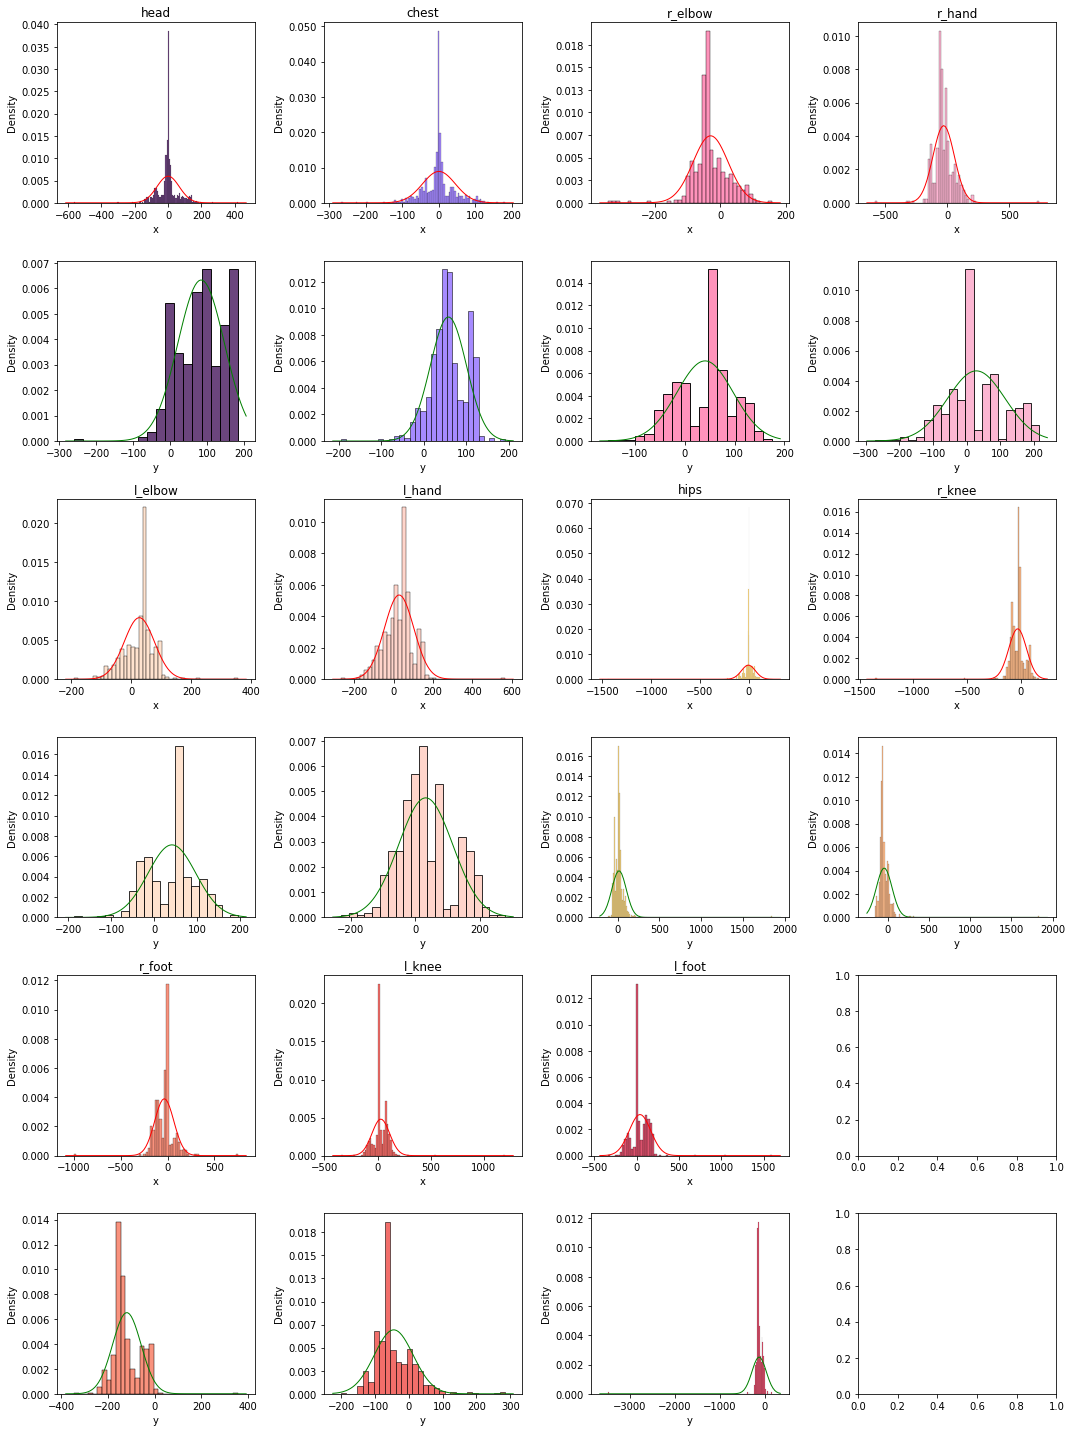

In [10]:
# A visualisation of the normality assumption which I didn't end up using for the report 
# since the data isn't broken down by pose, which is what we need to check the assumption for.
visualise(train_data)

In [11]:
# Calculate the prior probabilities and parameters of the conditional distributions
prior, means, st_devs = train(train_data)

In [12]:
# Run the model on the test data
predictions, true_labels = predict(test_data, prior, means, st_devs)

In [13]:
# Evaluate the model by checking the accuracy, precision, and recall
evaluate(predictions, true_labels)

Overall Accuracy:
    0.759

Multiclass Statistics / Evaluation
Multiclass Accuracy:
    bridge: 0.429
    childs: 0.917
    downwarddog: 0.867
    mountain: 0.867
    plank: 0.667
    seatedforwardbend: 0.444
    tree: 0.667
    trianglepose: 1.000
    warrior1: 0.800
    warrior2: 0.875
Multiclass Precision (Macro-Averaged):
    0.739
Multiclass Recall (Macro-Averaged):
    0.753
Multiclass F1 Score (Macro-Averaged):
    0.746
Multiclass Precision (Micro-Averaged):
    0.759
Multiclass Recall (Micro-Averaged):
    0.759
Multiclass F1 Score (Micro-Averaged):
    0.759


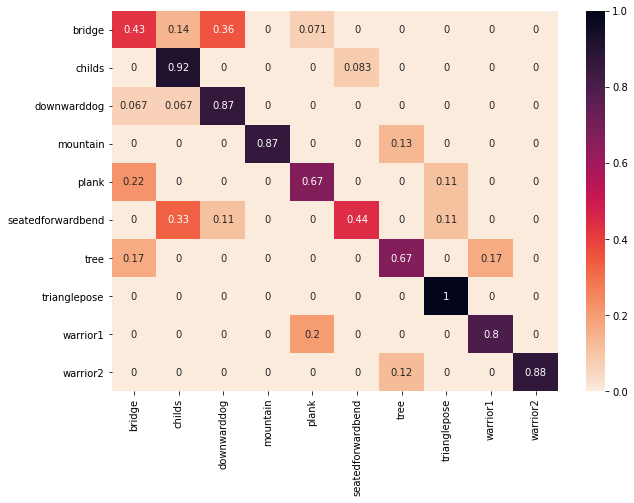

In [14]:
# Generate a confusion matrix
confuse(predictions, true_labels)

## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develop codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [17]:
def q1(predictions, true_labels):
    """Computes the Micro and Macro-Averaged multiclass evaluation statistics for the classification.
    This code is also included in the evaluate() function of the body of the code, which also includes
    the overall accuracy.
    
    The confusion matrix is extremely useful for extracting the TP, FP, and FN, so sklearn.metrics.confusion_matrix
    is used without normalisation to get the count of each classification (instead of proportion.)"""

    # Multiclass Statistics
    print('Multiclass Statistics / Evaluation')
    cm = confusion_matrix(true_labels, predictions)
    
    print('Multiclass Accuracy:')
    for i, pose in enumerate(poses):
        print(f'    {pose}: {cm[i][i] / sum(cm[i]):0.3f}')

    print('Multiclass Precision (Macro-Averaged):')
    mc_pres = 0
    tp_fp = np.sum(cm, axis=0)  # The vertical axis is all the elements that were classified as c
    for i, pose in enumerate(poses):
        mc_pres += cm[i][i] / tp_fp[i]
    mc_pres /= len(poses)
    print(f'    {mc_pres:0.3f}')

    print('Multiclass Recall (Macro-Averaged):')
    mc_rec = 0
    tp_fn = np.sum(cm, axis=1)  # The horizontal axis is all the elements that c was classified as
    for i, pose in enumerate(poses):
        mc_rec += cm[i][i] / tp_fn[i]
    mc_rec /= len(poses)
    print(f'    {mc_rec:0.3f}')

    print('Multiclass F1 Score (Macro-Averaged):')
    print(f'    {2*mc_pres*mc_rec / (mc_pres+mc_rec):0.3f}')

    print('Multiclass Precision (Micro-Averaged):')
    num = denom = 0
    for i, pose in enumerate(poses):
        num += cm[i][i]
        denom += tp_fp[i]
    print(f'    {(mc_pres := num / denom):0.3f}')

    print('Multiclass Recall (Micro-Averaged):')
    num = denom = 0
    for i, pose in enumerate(poses):
        num += cm[i][i]
        denom += tp_fn[i]
    print(f'    {(mc_rec := num / denom):0.3f}')

    print('Multiclass F1 Score (Micro-Averaged):')
    print(f'    {2*mc_pres*mc_rec / (mc_pres+mc_rec):0.3f}')

q1(predictions, true_labels)

Multiclass Statistics / Evaluation
Multiclass Accuracy:
    bridge: 0.429
    childs: 0.917
    downwarddog: 0.867
    mountain: 0.867
    plank: 0.667
    seatedforwardbend: 0.444
    tree: 0.667
    trianglepose: 1.000
    warrior1: 0.800
    warrior2: 0.875
Multiclass Precision (Macro-Averaged):
    0.739
Multiclass Recall (Macro-Averaged):
    7.531
Multiclass Precision (Micro-Averaged):
    0.759
Multiclass Recall (Micro-Averaged):
    0.759


### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

### __For this question I generated data visualisations in R. The R code for this question will also be included in the submission, and the plots I generated are included in the appendices of the report.__